In [1]:
%matplotlib inline
import sys
sys.path.append('../')

import data
import os
from PIL import Image
import numpy as np
from collections import defaultdict
import glob
from skimage import measure
import matplotlib.pyplot as plt
import shutil
import pandas as pd

/home/jfaath/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
sizes = defaultdict(lambda: 0)
perims = defaultdict(list)

src_dir = os.path.join('..', 'raw-data', 'train', '*', 'images')
flist = data.file_list(src_dir)
for cnt, f in enumerate(flist):
    img = Image.open(f)
    imga = np.asarray(img)
    sizes[imga.shape] += 1
    
    search_path = os.path.join(os.path.dirname(f), '..', 'masks', f"*.png")
    for mask_path in glob.glob(search_path):
        mask_img = Image.open(mask_path)
        mask_imga = np.asarray(mask_img)
        perims[imga.shape].append(measure.perimeter(mask_imga==255))

print(f"Finished")

Finished


(256, 256, 4): 334
(520, 696, 4): 92
(360, 360, 4): 91
(256, 320, 4): 112
(1024, 1024, 4): 16
(512, 640, 4): 13
(603, 1272, 4): 6
(1040, 1388, 4): 1
(260, 347, 4): 4
--------------------------
(256, 256, 4): avg_masks=28.55688622754491, avg_perim=45.47256522738182
(520, 696, 4): avg_masks=103.82608695652173, avg_perim=92.48299572013192
(360, 360, 4): avg_masks=23.45054945054945, avg_perim=145.4473786809811
(256, 320, 4): avg_masks=41.80357142857143, avg_perim=73.99571204514498
(1024, 1024, 4): avg_masks=84.0625, avg_perim=52.593600877732385
(512, 640, 4): avg_masks=31.615384615384617, avg_perim=136.74599111576717
(603, 1272, 4): avg_masks=229.5, avg_perim=46.01841867669534
(1040, 1388, 4): avg_masks=14.0, avg_perim=328.8821272007975
(260, 347, 4): avg_masks=101.75, avg_perim=47.311413335597095


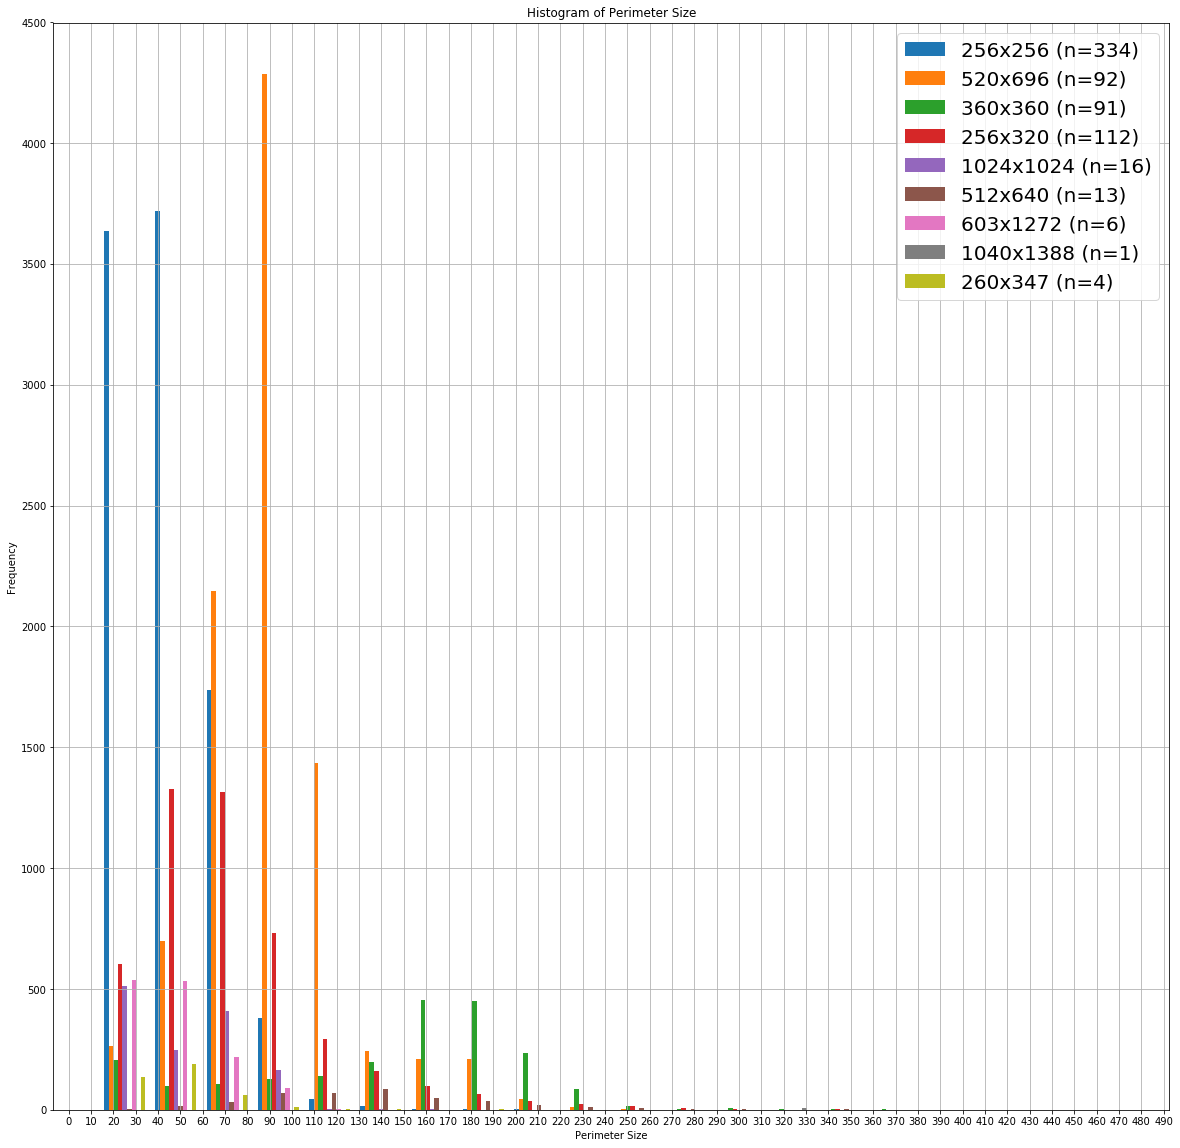

In [50]:
for k,v in sizes.items():
    print(f"{k}: {v}")
print('--------------------------')  
x = []
l = []
for k,v in perims.items():
    print(f"{k}: avg_masks={len(v) / sizes[k]}, avg_perim={sum(v) / len(v)}")
    x.append(v)
    l.append(f"{k[0]}x{k[1]} (n={sizes[k]})")

major_ticks = np.arange(0,500,10)
#minor_ticks = np.arange(0,500,25)
    
plt.figure(figsize=(20, 20))
n, bins, patches = plt.hist(x, 20, label=l)
plt.legend(prop={'size': 20})
plt.xlabel('Perimeter Size')
plt.ylabel('Frequency')
plt.title('Histogram of Perimeter Size')
ax = plt.gca()
ax.set_xticks(major_ticks)
#ax.set_xticks(minor_ticks, minor=True)
plt.grid(True)
plt.show()

In [16]:
# Get datafram of ratios
con_files = data.file_list('../train-og', fname_wildcard=f"*-con")
ratios = pd.DataFrame(columns=['id', 'ratio', 'rows', 'cols'])
for i, con_file in enumerate(con_files):
    con = np.asarray(Image.open(con_file))
    name, _ = os.path.splitext(os.path.basename(con_file))
    denom = np.prod(con.shape)
    numer = np.sum(con > 0)
    ratios.loc[i] = [name, (numer / denom), con.shape[0], con.shape[1]]
    
print(len(ratios))
#print(ratios[ratios.ratio == ratios.ratio.min()])

669


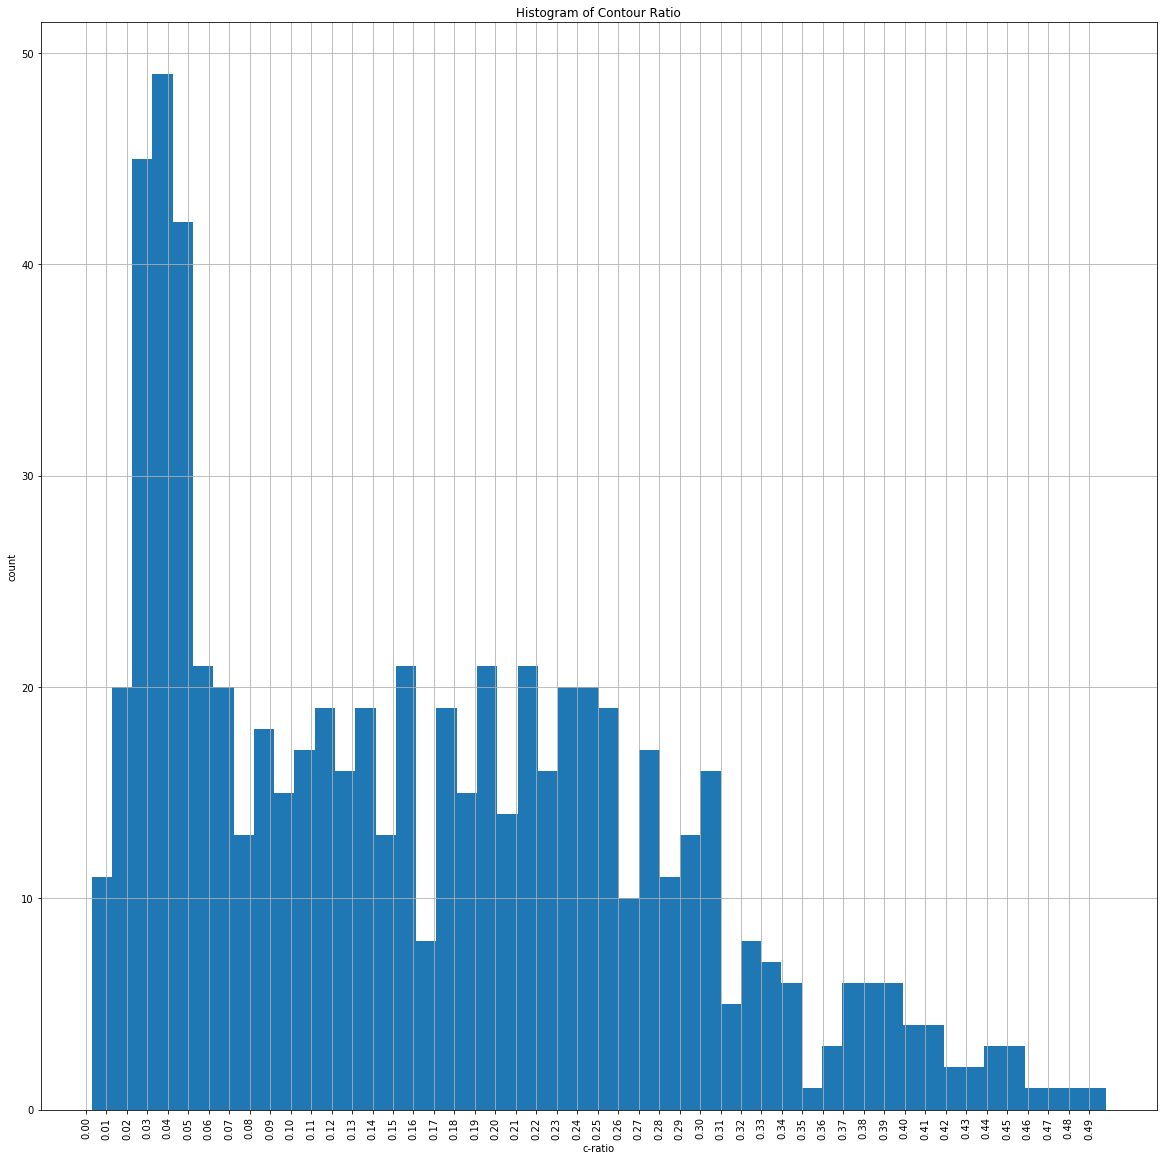

                                                    id     ratio  rows  cols
644  93c5638e7e6433b5c9cc87c152bcbe28873d2f9d6a392c...  0.002731   256   256
66   220b37f4ca7cab486d2b71cd87a46ee7411a5aa142799d...  0.003247   256   320
530  84eeec681987753029eb83ea5f3ff7e8b5697783cdb203...  0.004074   256   256
209  e5aeb5b3577abbebe8982b5dd7d22c4257250ad3000661...  0.004456   256   256
19   af576e8ec3a8d0b57eb6a311299e9e4fd2047970d3dd9d...  0.007251   256   320
142  866a8cba7bfe1ea73e383d6cf492e53752579140c8b833...  0.008695   520   696
634  93cfd412c7de5210bbd262ec3a602cfea65072e9272e9f...  0.010239   256   256
255  0b0d577159f0d6c266f360f7b8dfde46e16fa665138bf5...  0.011345   520   696
655  9cbc0700317361236a9fca2eb1f8f79e3a7da17b1970c1...  0.011551   256   256
304  07761fa39f60dc37022dbbe8d8694595fd5b77ceb2af2a...  0.011734   256   256
254  fa73f24532b3667718ede7ac5c2e24ad7d3cae17b0a42e...  0.012634   256   256
420  3d0ca3498d97edebd28dbc7035eced40baa4af199af09c...  0.014496   256   256

In [17]:
# Plot ratios
major_ticks = np.arange(0,0.5,0.01)

plt.figure(figsize=(20, 20))
n, bins, patches = plt.hist(ratios['ratio'].values, 50)
plt.xlabel('c-ratio')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.title('Histogram of Contour Ratio')
ax = plt.gca()
ax.set_xticks(major_ticks)
plt.grid(True)
plt.show()

print(ratios.sort_values('ratio').head(50))

In [224]:
# Test trials it takes to crop to a certain contour threshold
img_size = 256
con_ratio = 0.015
imgf = '../model-data/con-test/c15c652c08153fb781a5349123ab8f80bb2a8680a41eb8e89e547ae01b7a5441-con.png'
imga = np.asarray(Image.open(imgf))

top_max = imga.shape[0] - img_size + 1
left_max = imga.shape[1] - img_size + 1

for i in range(10000):
    top = np.random.randint(0, top_max)
    left = np.random.randint(0, left_max)
    crop = imga[top:top + img_size,left:left + img_size]
    ratio = np.sum(crop > 0) / np.prod(crop.shape)
    print(ratio)
    if ratio > con_ratio:
        break
        
print(i)

0.000534057617188
0.00164794921875
0.0
0.0
0.0361328125
4
